# Sistema de predicción de ventas

### Paso 1: Carga del conjunto de datos

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
data = pd.read_csv('/Users/julian/Desktop/vs code/TIME_SERIES_FORECASTING_Sistema_de_predicción_de_ventas_Project_23_Julian_Lopez/TIME_SERIES_FORECASTING_Sistema_de_predicci-n_de_ventas_Project_23_Julian_Lopez/data/raw/sales.csv')
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [28]:
data.shape

(366, 2)

In [29]:
data.isnull().sum()

date     0
sales    0
dtype: int64

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [31]:
data.duplicated().sum()

np.int64(0)

### Paso 2: Construye y analiza la serie temporal

#### Construyo la estructura de datos válida para la serie temporal

In [32]:
data['date'] = pd.to_datetime(data['date'])

In [33]:
data.set_index('date', inplace=True)

In [34]:
final_data = data["sales"]
final_data.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

#### Visualizo la serie temporal para llevar a cabo un análisis visual

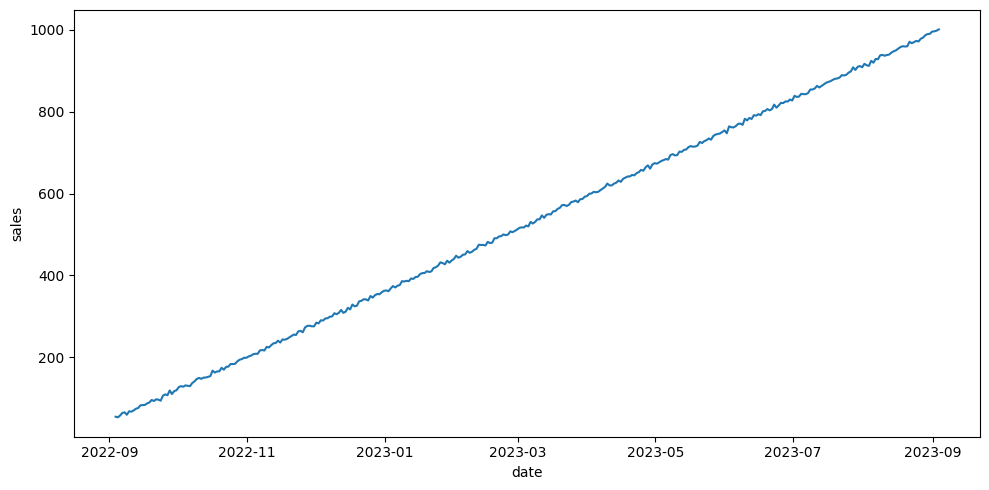

In [35]:

import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)

plt.tight_layout()

plt.show()

#### ¿Cuál es el tensor de la serie temporal?

Si no se especifica un número de pasos de tiempo (timesteps), la forma del tensor es simplemente una representación de la serie temporal tal cual, que en este caso es de dimensión (366, 1), donde:
366 es el número de datos (un dato por día).
1 es la cantidad de características (en este caso, solo sales).

#### Descoposición de la serie


In [40]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(final_data, period = 12)
decomposition

#### ¿Cuál es la tendencia?

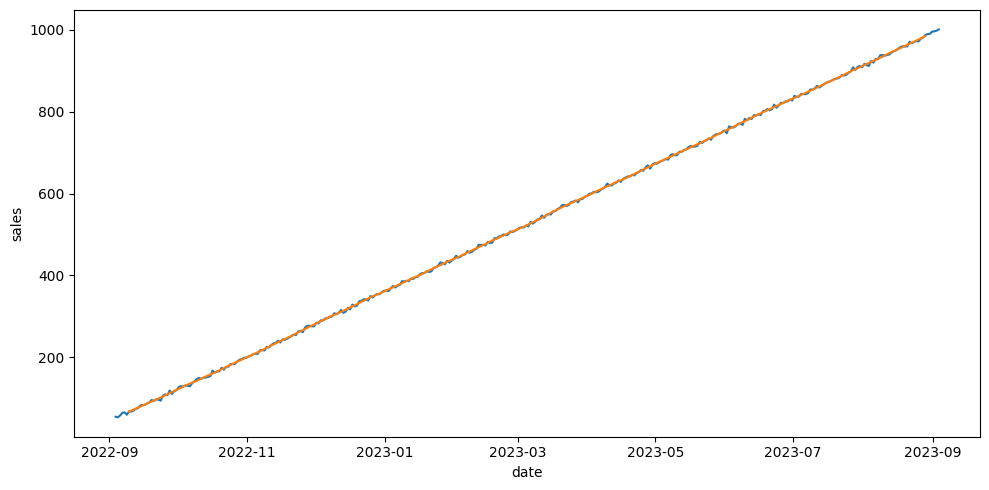

In [41]:
# Análisis de la tendencia

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()


Se confirma lo observado: una clara tendencia positiva a lo largo de los días.

#### ¿Es estacionaria?

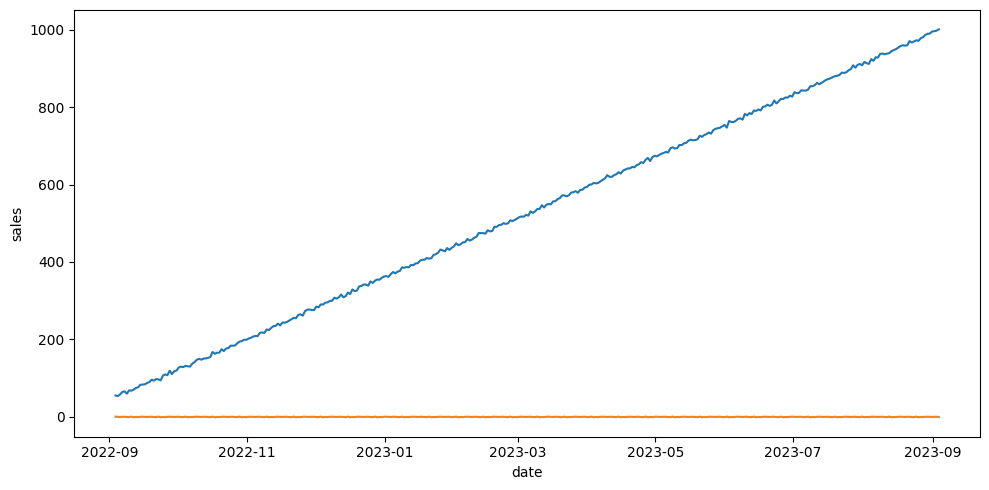

In [43]:
# Análisis de la estacionalidad

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [45]:
# Prueba de Dickey-Fuller (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(final_data)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

#### ¿Existe variabilidad o presencia de ruido?

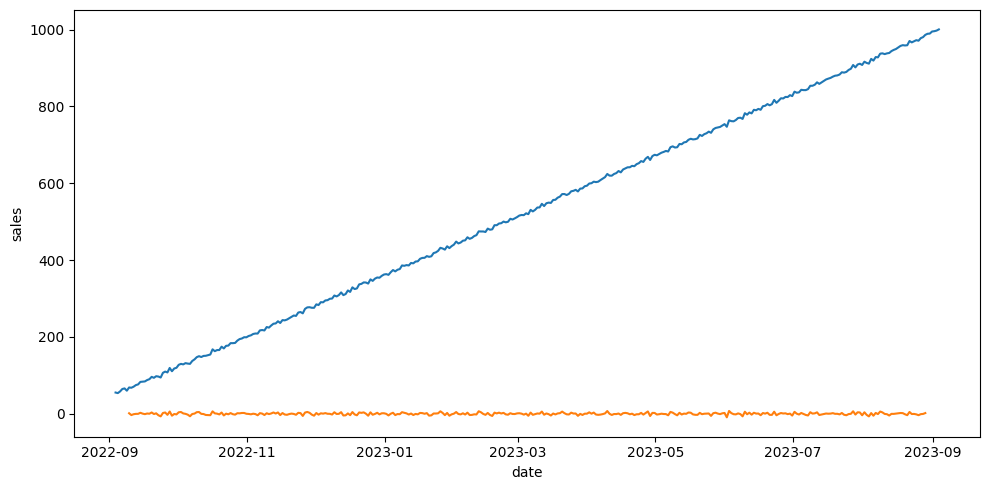

In [46]:
# Análisis de la variabilidad

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Como obserbamos, si existe variabilidad o presencia de ruido. Hay ruido en la serie, como se observa en los residuos después de la descomposición. Estas fluctuaciones no siguen una estructura clara y están centradas en cero, lo cual indica variabilidad aleatoria que no puede explicarse por la tendencia ni por un patrón estacional.

#### Análisis de la autocorrelación

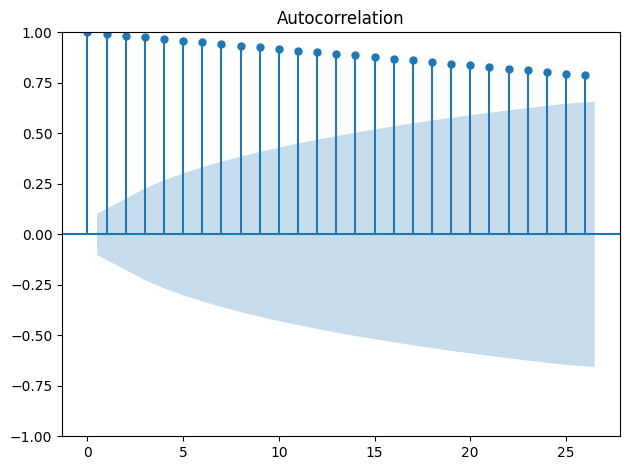

In [47]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(final_data)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye poco a poco a lo largo del tiempo.

### Paso 3: Entrena un ARIMA